In [6]:
import config
from config import *
%matplotlib inline

#Assemble the data such that PCA can go and look through to learn something

In [33]:
class XRF_spectra:
    
    def __init__(self, xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0001_2018_1.h5',
             BASE_PATCH_WIDTH=32, verbosity=False):
        self.xrf_filename =xrf_filename
        self.BASE_PATCH_WIDTH=BASE_PATCH_WIDTH
        
        
        
    def load_xrf_data(self, hdf5_string = 'exchange_4'):
#         global d_Cu, d_Zn, d_Ca, d_K, d_P, d_S,d_Fe, d_Ni, d_TFY
    
        norm_ch = NORM_CH
        norm_ch = 'US_IC'
        value_offset=VALUE_OFFSET
        xrfdata = collections.defaultdict(list)

        with h5py.File(self.xrf_filename, 'r') as dat:
            groups= list(dat.keys())
            print('groups', groups)
            maps= list(dat['MAPS'].keys())
            print('maps', maps)
            chs = dat['MAPS/channel_names'][:].astype(str).tolist()
        #         dat['MAPS/']
            
            print('chs:', chs)
            
            self.int_spec=dat['MAPS/int_spec'][:].astype(int).tolist()
            self.energy=dat['MAPS/energy'][:].astype(int).tolist()
            
            self.mca_arr=dat['MAPS/mca_arr'][:].astype(int).tolist()
            self.scan_time_stamp=dat['MAPS/scan_time_stamp']
            print(self.scan_time_stamp)
            xrf = dat['MAPS/XRF_roi'][:]
        #         print(xrf)

            scaler_names = dat['MAPS/scaler_names'][:].astype(str).tolist()
            print('scaler_names:', scaler_names)
            scaler_val = dat['MAPS/scalers'][:]
#             print(scaler_val)
            norm = scaler_val[scaler_names.index(norm_ch)]
            print('norm:', norm)
            for e in chs:
                chidx = chs.index(e)
                xrfdata[e].append(xrf[chidx]/norm)
            xrfdata['scan_num'].append(self.xrf_filename)

            hdf5_string = hdf5_string

            xrfdata['x_axis'].append(dat[hdf5_string + '/x_axis'][:])
            xrfdata['y_axis'].append(dat[hdf5_string + '/y_axis'][:])

        #         xrfdata['x_axis'].append(dat['exchange_4/x_axis'][:])
        #         xrfdata['y_axis'].append(dat['exchange_4/y_axis'][:])
        xrfdata = pd.DataFrame(xrfdata)
        #     print(xrfdata)

        elms=['Cu','Zn','Ca', 'K', 'P', 'S','Fe','Ni','Total_Fluorescence_Yield']#Default elms
        for i, row in xrfdata.iterrows():
                sc = row['scan_num'][0:row['scan_num'].index('.')]
                for e in elms:
                    d = row[e]

                    d[np.isnan(d) | np.isinf(d)] = 0
                    norm_d = (d - np.min(d)) / (np.max(d) - np.min(d)) + value_offset
                    ss = np.round(np.abs(np.diff(row['x_axis']))[0], 2)
                    if e == 'Cu':
                        self.d_Cu=d
                        self.norm_d_Cu=norm_d
                        x_Cu,y_Cu=row['x_axis'], row['y_axis']
                    if e == 'Zn':
                        self.d_Zn=d
                        self.norm_d_Zn=norm_d
                        x_Zn,y_Zn=row['x_axis'], row['y_axis']
                    if e == 'Ca':
                        self.d_Ca=d
                        self.norm_d_Ca=norm_d
                        x_Ca,y_Ca=row['x_axis'], row['y_axis']
                    if e == 'K':
                        self.d_K=d
                        self.norm_d_K=norm_d
                        x_K,y_K=row['x_axis'], row['y_axis']
                    if e == 'P':
                        self.d_P=d
                        self.norm_d_P=norm_d
                        x_P,y_P=row['x_axis'], row['y_axis']
                    if e == 'S':
                        self.d_S=d
                        self.norm_d_S=norm_d
                        x_S,y_S=row['x_axis'], row['y_axis']

                    if e == 'Fe':
                        self.d_Fe=d
                        self.norm_d_Fe=norm_d
                        x_Fe,y_Fe=row['x_axis'], row['y_axis']

                    if e == 'Ni':
                        self.d_Ni=d
                        self.norm_d_Ni=norm_d
                        x_Ni,y_Ni=row['x_axis'], row['y_axis']

                    if e == 'Total_Fluorescence_Yield':
                        self.d_TFY=d
                        self.norm_d_TFY=norm_d
                        x_TFY,y_TFY=row['x_axis'], row['y_axis']
        #     print('Image shape: ',d.shape)
        
                    
    def add_noise(self, noise='none'):
        self.noise=noise
        if self.noise == 'normal':
            np.random.seed(0)
            self.normal_noise=abs(np.random.normal(0, 1, self.d_Cu.shape))
            self.d_Cu = self.d_Cu*(1+self.normal_noise) 
            self.d_Zn = self.d_Zn*(1+self.normal_noise)
            self.d_Ca = self.d_Ca*(1+self.normal_noise)
            self.d_K = self.d_K*(1+self.normal_noise)
            self.d_P = self.d_P*(1+self.normal_noise)
            self.d_S = self.d_S*(1+self.normal_noise)
            self.d_Fe = self.d_Fe*(1+self.normal_noise)
            self.d_Ni = self.d_Ni*(1+self.normal_noise)
            self.d_TFY = self.d_TFY*(1+self.normal_noise)
            
        elif self.noise == 'poisson':
            np.random.seed(0)
            self.poisson_noise=abs(np.random.poisson(1000, self.d_Cu.shape))
            self.d_Cu = self.d_Cu*(1+self.poisson_noise) 
            self.d_Zn = self.d_Zn*(1+self.poisson_noise)
            self.d_Ca = self.d_Ca*(1+self.poisson_noise)
            self.d_K = self.d_K*(1+self.poisson_noise)
            self.d_P = self.d_P*(1+self.poisson_noise)
            self.d_S = self.d_S*(1+self.poisson_noise)
            self.d_Fe = self.d_Fe*(1+self.poisson_noise)
            self.d_Ni = self.d_Ni*(1+self.poisson_noise)
            self.d_TFY = self.d_TFY*(1+self.poisson_noise)


        
    
    
    def binary_conversion(self, e='Cu'):
        #choose elemental channel for conversion
        
        if e == 'Cu':
            data_original = self.d_Cu
            
        if e == 'Zn':
            data_original = self.d_Zn
            
        if e == 'Ca':
            data_original = self.d_Ca
            
        if e == 'K':
            data_original = self.d_K
            
        if e == 'P':
            data_original = self.d_P
            
        if e == 'S':
            data_original = self.d_S
            

        if e == 'Fe':
            data_original = self.d_Fe
            

        if e == 'Ni':
            data_original = self.d_Ni
            
        if e == 'TFY':
            data_original = self.d_TFY
            
#         data_original=d_Cu
        data=data_original
        data = ndimage.median_filter(data, size=3)


        thresh = 1.5*threshold_otsu(data)
        binary = data < thresh
        binary = binary^1


        binary_eroded=ndimage.binary_erosion(binary).astype(binary.dtype)
        binary_dilated=ndimage.binary_dilation(binary).astype(binary.dtype)
        self.binary_ero_dil=ndimage.binary_dilation(binary_eroded).astype(binary_eroded.dtype)
        
        self.labeled_array, self.num_features = label(self.binary_ero_dil)
        
    def extract_cells(self):
        self.regions = measure.regionprops(self.labeled_array)    
        # print(len(regions))

        self.cell_list = []
        self.center_list = []
        self.Patches_Cu = []
        self.Patches_Zn = []
        self.Patches_Ca = []
        self.Patches_K = []
        self.Patches_P = []
        self.Patches_S = []
        self.Patches_Fe = []
        self.Patches_Ni = []
        self.Patches_TFY= []
        self.binary_img=[]
        self.region_vals=[]
        self.features_list = []

        for idx in range(len(self.regions)):
            self.cell_val_bin=self.regions[idx].image

            self.region_vals.append(self.cell_val_bin)
            self.padded_cell = np.pad(self.cell_val_bin, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.cell_list.append(self.padded_cell)
            self.center_list.append([math.floor(self.regions[idx].centroid[0]), math.floor(self.regions[idx].centroid[1])])
        #     regions[idx].bbox

            self.cell_Cu = self.d_Cu[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_Zn = self.d_Zn[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_Ca = self.d_Ca[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_K = self.d_K[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_P = self.d_P[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_S = self.d_S[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_Fe = self.d_Fe[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_Ni = self.d_Ni[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_TFY = self.d_TFY[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]

            self.padded_bin = np.pad(self.cell_val_bin, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_Cu = np.pad(self.cell_Cu, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_Zn = np.pad(self.cell_Cu, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_Ca = np.pad(self.cell_Cu, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_K = np.pad(self.cell_K, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_P = np.pad(self.cell_P, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_S = np.pad(self.cell_S, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_Fe = np.pad(self.cell_Fe, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_Ni = np.pad(self.cell_Ni, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_TFY = np.pad(self.cell_TFY, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))

            self.binary_img.append(self.padded_bin)
            self.Patches_Cu.append(self.padded_Cu)
            self.Patches_Zn.append(self.padded_Zn)
            self.Patches_Ca.append(self.padded_Ca)
            self.Patches_K.append(self.padded_K)
            self.Patches_P.append(self.padded_P)
            self.Patches_S.append(self.padded_S)
            self.Patches_Fe.append(self.padded_Fe)
            self.Patches_Ni.append(self.padded_Ni)
            self.Patches_TFY.append(self.padded_TFY)


            # define feature vector using averages
        #     x = np.asarray([regions[idx].area, 
        #      regions[idx].eccentricity, 
        #      regions[idx].equivalent_diameter, 
        #      regions[idx].major_axis_length,
        #      regions[idx].minor_axis_length,
        #      regions[idx].perimeter,
        #      np.average(Patches_K[idx]),
        #      np.average(Patches_K[idx])/np.average(Patches_P[idx]),
        #      np.average(Patches_Ni[idx]),
        #      np.average(Patches_Ni[idx])/np.average(Patches_P[idx]),
        #     np.average(Patches_Ni[idx])/np.average(Patches_K[idx]),
        #     np.average(Patches_Cu[idx])/np.average(Patches_K[idx]),
        #     ])

            # define feature vector using averages
            self.x = np.asarray([0.25*0.25*self.regions[idx].area, 
             self.regions[idx].eccentricity, 
             0.25*self.regions[idx].equivalent_diameter, 
             0.25*self.regions[idx].major_axis_length,
             0.25*self.regions[idx].minor_axis_length,
             0.25*self.regions[idx].perimeter,
             np.amax(self.Patches_K[idx]),
             np.amax(self.Patches_P[idx]),
             np.amax(self.Patches_Ni[idx]),
             np.amax(self.Patches_Zn[idx]),
            np.amax(self.Patches_Fe[idx]),
            np.amax(self.Patches_Cu[idx]),
            np.amax(self.Patches_TFY[idx]-self.Patches_K[idx]-self.Patches_P[idx]-self.Patches_Ni[idx]-self.Patches_Zn[idx]-self.Patches_Fe[idx]-self.Patches_Cu[idx]),
            np.unique(x.region_vals[idx], return_counts=True)[1][1] # returns the number of true (1's) values in the identified region
            ])

            self.features_list.append(self.x)
        self.features=np.asarray(self.features_list)



In [17]:
xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0001_2018_1.h5'
with h5py.File(xrf_filename, 'r') as dat:
            groups= list(dat.keys())
            print(groups)
            maps= list(dat['MAPS'].keys())
            chs = dat['MAPS/channel_names'][:].astype(str).tolist()
        #         dat['MAPS/']
            
            int_spec=dat['MAPS/int_spec'][:].astype(int).tolist()
            energy=dat['MAPS/energy'][:].astype(int).tolist()
            print(maps)
#             mca_arr=dat['MAPS/mca_arr'][:].astype(int).tolist()
            my_var=dat['MAPS/ds_amp'][:].astype(str).tolist()
            print(my_var)
            xrf = dat['MAPS/XRF_roi'][:]
        #         print(xrf)

            scaler_names = dat['MAPS/scaler_names'][:].astype(str).tolist()
            scaler_val = dat['MAPS/scalers'][:]
#             norm = scaler_val[scaler_names.index(norm_ch)]
            print(scaler_val)

['MAPS', 'exchange_0', 'exchange_1', 'exchange_2', 'exchange_3', 'exchange_4']
['XRF_fits', 'XRF_fits_quant', 'XRF_roi', 'XRF_roi_plus', 'XRF_roi_plus_quant', 'XRF_roi_quant', 'add_float', 'add_long', 'add_string', 'channel_names', 'channel_units', 'ds_amp', 'energy', 'energy_calib', 'extra_pvs', 'extra_pvs_as_csv', 'extra_strings', 'int_spec', 'make_maps_conf', 'max_chan_spec', 'mca_arr', 'scaler_names', 'scaler_units', 'scalers', 'scan_time_stamp', 'us_amp', 'version', 'write_date', 'x_axis', 'y_axis']
['0.0', '0.0', '0.0']
[[[     0.        0.        0.   ...      0.        0.        0.  ]
  [     0.        0.        0.   ...      0.        0.        0.  ]
  [     0.        0.        0.   ...      0.        0.        0.  ]
  ...
  [     0.        0.        0.   ...      0.        0.        0.  ]
  [     0.        0.        0.   ...      0.        0.        0.  ]
  [     0.        0.        0.   ...      0.        0.        0.  ]]

 [[325297.75 328247.7  322803.16 ... 326965.   32458

In [14]:
scan_time_stamp

NameError: name 'scan_time_stamp' is not defined

In [ ]:
noise_type = 'none'

In [9]:
x= XRF_spectra(xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0001_2018_1.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='exchange_4')
# x.add_noise(noise=noise_type)

x.binary_conversion(e='Cu')
x.extract_cells()
X_bin1=x.binary_img  


X_Cu1=x.Patches_Cu
X_Zn1=x.Patches_Zn
X_Ca1=x.Patches_Ca
X_K1=x.Patches_K
X_P1=x.Patches_P
X_S1=x.Patches_S
X_Fe1=x.Patches_Fe
X_Ni1=x.Patches_Ni
X_TFY1=x.Patches_TFY

X1=x.features
X1.shape

['XRF_fits', 'XRF_fits_quant', 'XRF_roi', 'XRF_roi_plus', 'XRF_roi_plus_quant', 'XRF_roi_quant', 'add_float', 'add_long', 'add_string', 'channel_names', 'channel_units', 'ds_amp', 'energy', 'energy_calib', 'extra_pvs', 'extra_pvs_as_csv', 'extra_strings', 'int_spec', 'make_maps_conf', 'max_chan_spec', 'mca_arr', 'scaler_names', 'scaler_units', 'scalers', 'scan_time_stamp', 'us_amp', 'version', 'write_date', 'x_axis', 'y_axis']
<HDF5 dataset "scan_time_stamp": shape (), type "|S29">


(110, 14)

In [10]:
x.scan_time_stamp

<Closed HDF5 dataset>

In [11]:
len(x.energy)

2048

In [12]:
len(x.mca_arr)

2000

In [14]:
x.mca_arr[0]

[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


In [29]:
len(x.int_spec)

2048

In [20]:
len(x.my_variable)

2048

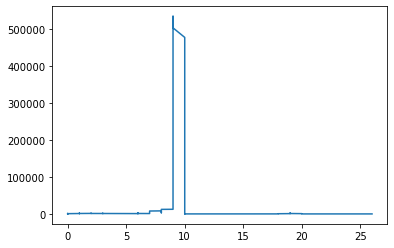

In [39]:
plt.plot(x.energy, x.int_spec)

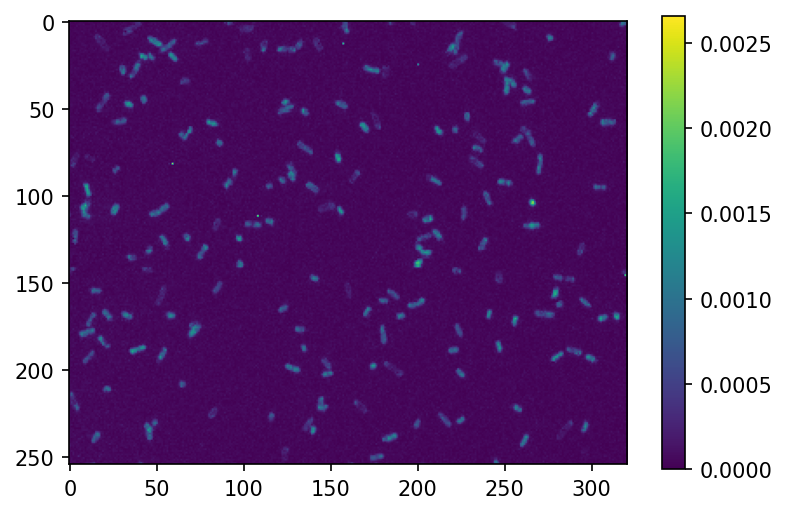

In [5]:
x.noise
plt.figure(dpi=150)
plt.imshow(x.d_Cu)
plt.colorbar()

In [4]:
xrf_filename = '/data02/AZC/beamtime_data/bnp_fly0125.mda.h5'
with h5py.File(xrf_filename, 'r') as dat:
            groups= list(dat.keys())
            print(groups)
            maps= list(dat['MAPS'].keys())
            chs = dat['MAPS/channel_names'][:].astype(str).tolist()
        #         dat['MAPS/']
            
            int_spec=dat['MAPS/int_spec'][:].astype(int).tolist()
            energy=dat['MAPS/energy'][:].astype(int).tolist()
            print(maps)
#             mca_arr=dat['MAPS/mca_arr'][:].astype(int).tolist()
            my_var=dat['MAPS/ds_amp'][:].astype(str).tolist()
            print(my_var)
            xrf = dat['MAPS/XRF_roi'][:]
        #         print(xrf)

            scaler_names = dat['MAPS/scaler_names'][:].astype(str).tolist()
            scaler_val = dat['MAPS/scalers'][:]
#             norm = scaler_val[scaler_names.index(norm_ch)]
            print(scaler_val)

['MAPS', 'version']
['Quantification', 'Scalers', 'Scan', 'Spectra', 'XRF_Analyzed', 'XRF_roi', 'XRF_roi_plus', 'XRF_roi_plus_quant', 'XRF_roi_quant', 'channel_names', 'channel_units', 'ds_amp', 'energy', 'energy_calib', 'extra_pvs', 'int_spec', 'make_maps_conf', 'max_chan_spec', 'mca_arr', 'scaler_names', 'scaler_units', 'scalers', 'scan_time_stamp', 'us_amp', 'version', 'x_axis', 'y_axis']
['0.0', '0.0', '1.0']
[[[ 1.18325898e+05  1.19044633e+05  1.18502672e+05 ...  1.18906312e+05
    1.18495594e+05  1.18693805e+05]
  [ 1.18523250e+05  1.18645211e+05  1.18536883e+05 ...  1.18361555e+05
    1.17801250e+05  1.18774719e+05]
  [ 1.18457344e+05  1.18118312e+05  1.18166547e+05 ...  1.17699695e+05
    1.18223562e+05  1.19058516e+05]
  ...
  [ 1.19409359e+05  1.19072242e+05  1.18985898e+05 ...  1.18502609e+05
    1.18338273e+05  1.19005961e+05]
  [ 1.18821438e+05  1.19422719e+05  1.19123273e+05 ...  1.19593531e+05
    1.18807258e+05  1.18734117e+05]
  [ 1.18909562e+05  1.19456109e+05  1.1809

In [54]:
x= XRF_spectra(xrf_filename = '/data02/AZC/beamtime_data/bnp_fly0124.mda.h5',
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='MAPS')
# x.add_noise(noise=noise_type)

x.binary_conversion(e='Cu')
x.extract_cells()
X_bin1=x.binary_img  


X_Cu1=x.Patches_Cu
X_Zn1=x.Patches_Zn
X_Ca1=x.Patches_Ca
X_K1=x.Patches_K
X_P1=x.Patches_P
X_S1=x.Patches_S
X_Fe1=x.Patches_Fe
X_Ni1=x.Patches_Ni
X_TFY1=x.Patches_TFY

X1=x.features
X1.shape

groups ['MAPS', 'version']
maps ['Quantification', 'Scalers', 'Scan', 'Spectra', 'XRF_Analyzed', 'XRF_roi', 'XRF_roi_plus', 'XRF_roi_plus_quant', 'XRF_roi_quant', 'channel_names', 'channel_units', 'ds_amp', 'energy', 'energy_calib', 'extra_pvs', 'int_spec', 'make_maps_conf', 'max_chan_spec', 'mca_arr', 'scaler_names', 'scaler_units', 'scalers', 'scan_time_stamp', 'us_amp', 'version', 'x_axis', 'y_axis']
chs: ['Al', 'Si', 'P', 'S', 'Cl', 'K', 'Ca', 'Ti', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Si_Cl', 'Total_Fluorescence_Yield', 'Si_Si', 'Cl_Cl', 'COHERENT_SCT_AMPLITUDE', 'COMPTON_AMPLITUDE', 'Num_Iter', 'Fit_Residual', 'Sum_Elastic_Inelastic']
<HDF5 dataset "scan_time_stamp": shape (1,), type "|S256">
scaler_names: ['CFG_2', 'CFG_3', 'CFG_4', 'CFG_5', 'DS_IC', 'Dead_Time', 'ELT', 'ERT', 'H_dpc_cfg', 'ICR1', 'ICR2', 'ICR3', 'ICR4', 'INCNT', 'OCR1', 'OCR2', 'OCR3', 'OCR4', 'OUTCNT', 'US_IC', 'V_dpc_cfg', 'abs_cfg', 'abs_ic', 'dia1_dpc_cfg', 'dia2_dpc_cfg']
norm: [[153769.9  155330.52 

(0,)

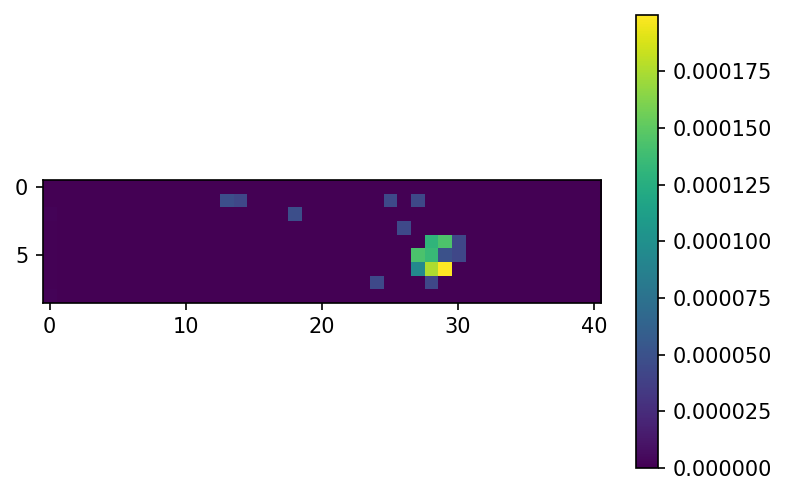

In [60]:
# x.noise
plt.figure(dpi=150)
plt.imshow(x.d_Cu)
plt.colorbar()

In [56]:
x.d_Cu.shape

(9, 41)

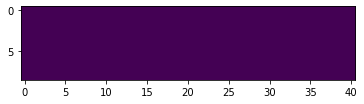

In [57]:
plt.imshow(x.binary_ero_dil)

In [58]:
len(x.region_vals)

0

In [59]:
plt.imshow(x.region_vals[0])

IndexError: list index out of range